In [ ]:
import keras
from keras import layers
from PIL import Image
from IPython.core.display import Path
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs")


100%|██████████| 202M/202M [00:11<00:00, 18.2MB/s]


In [ ]:
def Split_Preprocessing(path_train, path_test,num_train=1000,num_test=10):
    x_train = list()
    x_test = list()

    y_train = list()
    y_test = list()
    # iterate over files in
    # that directory
    files = Path(path_train).glob('*')
    # print('------------------train images---------------')
    for i,file in enumerate(files):
        # if(i==num_train):
        #   break
        im = Image.open(file)
        im = im.resize(size=(256,128))
        na = np.array(im)
        X = na[:128, :128, :]
        Y = na[ :128, 128: , : ]
        if len(na.shape) == 3:
          if na.shape[2] == 3:
            x_train.append(X)
            y_train.append(Y)

    # print("===================test images=====================")
    files = Path(path_test).glob('*')
    for i,file in enumerate(files):
        if(i==num_test):
          break
        im = Image.open(file)
        im = im.resize(size=(256,128))
        # plt.imshow(im)
        na = np.array(im)
        X = na[:128, :128, :]
        Y = na[ :128, 128: , : ]
        if len(na.shape) == 3:
          if na.shape[2] == 3:
            x_test.append(X)
            y_test.append(Y)

    return np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test)
x_train, x_test, y_train, y_test =Split_Preprocessing('/content/cityscapes-image-pairs/cityscapes_data/train','/content/cityscapes-image-pairs/cityscapes_data/val')

In [ ]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
y_train = y_train.astype('float32') / 255
y_test = y_test.astype('float32') / 255

In [ ]:
y_train.shape

(2975, 128, 128, 3)

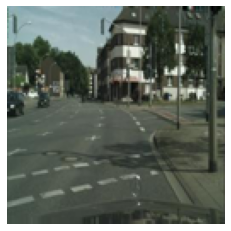

In [ ]:
plt.axis("off")
plt.imshow((x_train[0]))
plt.show()

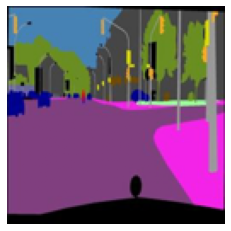

In [ ]:
plt.axis("off")
plt.imshow((y_train[0]))
plt.show()

##**U Net Arc.**

In [ ]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [ ]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

In [ ]:
def build_unet_model():
   inputs = layers.Input(shape=(128,128,3))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 32)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 64)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 128)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 256)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 512)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 256)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 128)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 64)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 32)
   # outputs
   outputs = layers.Conv2D(3, 1, padding="same", activation = "sigmoid")(u9)
   # unet model with Keras Functional API
   unet_model = keras.Model(inputs, outputs, name="U-Net")

   return unet_model


unet_model = build_unet_model()
unet_model.compile(optimizer='adam', loss="mse")

unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_76 (Conv2D)             (None, 128, 128, 32  896         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_77 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_76[0][0]']              
                                )                                                             

In [ ]:
history = unet_model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
93/93 [==============================] - 26s 231ms/step - loss: 0.0410 - val_loss: 0.0248
Epoch 2/50
93/93 [==============================] - 17s 185ms/step - loss: 0.0242 - val_loss: 0.0214
Epoch 3/50
93/93 [==============================] - 17s 188ms/step - loss: 0.0209 - val_loss: 0.0178
Epoch 4/50
93/93 [==============================] - 18s 190ms/step - loss: 0.0181 - val_loss: 0.0156
Epoch 5/50
93/93 [==============================] - 18s 190ms/step - loss: 0.0167 - val_loss: 0.0158
Epoch 6/50
93/93 [==============================] - 18s 190ms/step - loss: 0.0161 - val_loss: 0.0146
Epoch 7/50
93/93 [==============================] - 18s 189ms/step - loss: 0.0152 - val_loss: 0.0153
Epoch 8/50
93/93 [==============================] - 18s 189ms/step - loss: 0.0146 - val_loss: 0.0129
Epoch 9/50
93/93 [==============================] - 18s 190ms/step - loss: 0.0138 - val_loss: 0.0139
Epoch 10/50
93/93 [==============================] - 18s 190ms/step - loss: 0.0136 - val_lo

In [ ]:
masks = unet_model.predict(x_test)

1/1 [==============================] - 0s 217ms/step


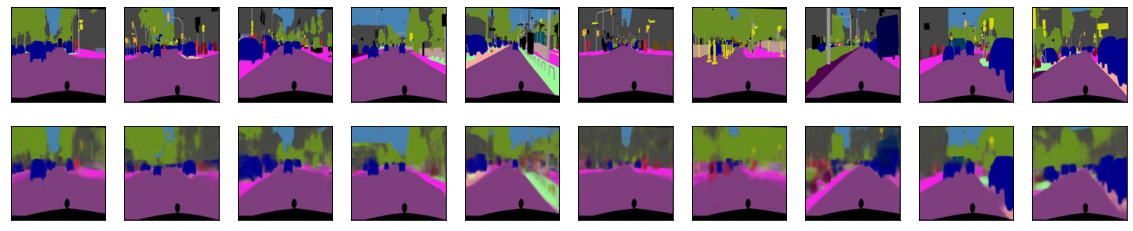

In [ ]:
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(0, n ):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(y_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n + 1 )
    plt.imshow(np.clip(masks[i], 0., 1.))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
def build_unet_model():
   inputs = layers.Input(shape=(128,128,3))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)
   # outputs
   outputs = layers.Conv2D(3, 1, padding="same", activation = "sigmoid")(u9)
   # unet model with Keras Functional API
   unet_model = keras.Model(inputs, outputs, name="U-Net")

   return unet_model


unet_model = build_unet_model()
unet_model.compile(optimizer='adam', loss="mse")

unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_95 (Conv2D)             (None, 128, 128, 64  1792        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_96 (Conv2D)             (None, 128, 128, 64  36928       ['conv2d_95[0][0]']              
                                )                                                             

In [ ]:
history = unet_model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
93/93 [==============================] - 26s 231ms/step - loss: 0.0410 - val_loss: 0.0248
Epoch 2/50
93/93 [==============================] - 17s 185ms/step - loss: 0.0242 - val_loss: 0.0214
Epoch 3/50
93/93 [==============================] - 17s 188ms/step - loss: 0.0209 - val_loss: 0.0178
Epoch 4/50
93/93 [==============================] - 18s 190ms/step - loss: 0.0181 - val_loss: 0.0156
Epoch 5/50
93/93 [==============================] - 18s 190ms/step - loss: 0.0167 - val_loss: 0.0158
Epoch 6/50
93/93 [==============================] - 18s 190ms/step - loss: 0.0161 - val_loss: 0.0146
Epoch 7/50
93/93 [==============================] - 18s 189ms/step - loss: 0.0152 - val_loss: 0.0153
Epoch 8/50
93/93 [==============================] - 18s 189ms/step - loss: 0.0146 - val_loss: 0.0129
Epoch 9/50
93/93 [==============================] - 18s 190ms/step - loss: 0.0138 - val_loss: 0.0139
Epoch 10/50
93/93 [==============================] - 18s 190ms/step - loss: 0.0136 - val_lo

In [ ]:
masks = unet_model.predict(x_test)

1/1 [==============================] - 0s 217ms/step


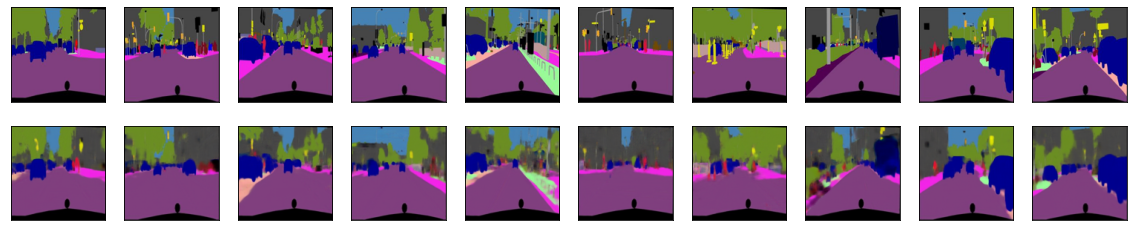

In [ ]:
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(0, n ):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(y_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n + 1 )
    plt.imshow(np.clip(masks[i], 0., 1.))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
def build_unet_model():
   inputs = layers.Input(shape=(128,128,3))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 32)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 64)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 128)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 256)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 512)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 256)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 128)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 64)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 32)
   # outputs
   outputs = layers.Conv2D(3, 1, padding="same", activation = "sigmoid")(u9)
   # unet model with Keras Functional API
   unet_model = keras.Model(inputs, outputs, name="U-Net")

   return unet_model


unet_model = build_unet_model()
unet_model.compile(optimizer='adam', loss="binary_crossentropy")

unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_19[0][0]']              
                                )                                                             

In [ ]:
history = unet_model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

Epoch 1/20
93/93 [==============================] - 33s 219ms/step - loss: 0.6273 - val_loss: 0.5939
Epoch 2/20
93/93 [==============================] - 16s 174ms/step - loss: 0.5901 - val_loss: 0.5860
Epoch 3/20
93/93 [==============================] - 16s 174ms/step - loss: 0.5808 - val_loss: 0.5763
Epoch 4/20
93/93 [==============================] - 16s 176ms/step - loss: 0.5756 - val_loss: 0.5754
Epoch 5/20
93/93 [==============================] - 16s 177ms/step - loss: 0.5737 - val_loss: 0.5716
Epoch 6/20
93/93 [==============================] - 17s 178ms/step - loss: 0.5704 - val_loss: 0.5752
Epoch 7/20
93/93 [==============================] - 17s 178ms/step - loss: 0.5686 - val_loss: 0.5725
Epoch 8/20
93/93 [==============================] - 17s 179ms/step - loss: 0.5667 - val_loss: 0.5700
Epoch 9/20
93/93 [==============================] - 17s 180ms/step - loss: 0.5654 - val_loss: 0.5695
Epoch 10/20
93/93 [==============================] - 17s 181ms/step - loss: 0.5651 - val_lo

In [ ]:
masks = unet_model.predict(x_test)

1/1 [==============================] - 0s 20ms/step


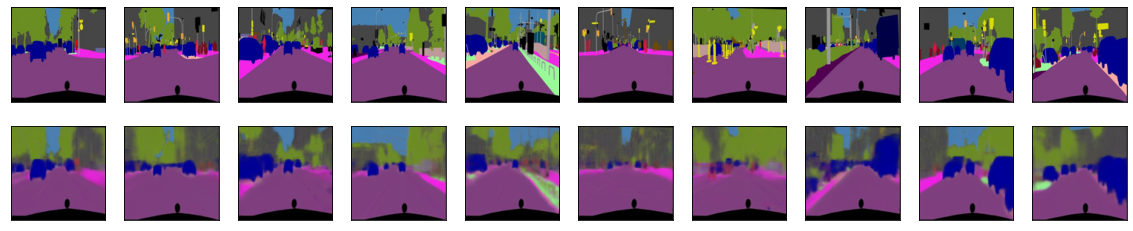

In [ ]:
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(0, n ):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(y_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n + 1 )
    plt.imshow(np.clip(masks[i], 0., 1.))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
encoding_dim = 32
input_img = keras.Input(shape=(784,))

x = layers.Dense(100, activation='relu')(input_img)

encoded = layers.Dense(encoding_dim, activation='relu')(x)

x = layers.Dense(100, activation='relu')(encoded)

decoded = layers.Dense(784, activation='sigmoid')(x)

autoencoder = keras.Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

encoder = keras.Model(input_img, encoded)

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 32)                3232      
                                                                 
 dense_2 (Dense)             (None, 100)               3300      
                                                                 
 dense_3 (Dense)             (None, 784)               79184     
                                                                 
Total params: 164,216
Trainable params: 164,216
Non-trainable params: 0
_________________________________________________________________


In [ ]:
len(autoencoder.weights)

8

In [ ]:
autoencoder.weights

[<tf.Variable 'dense/kernel:0' shape=(784, 100) dtype=float32, numpy=
 array([[ 0.05985969,  0.03478066,  0.07009651, ...,  0.04544339,
          0.08103831, -0.05441488],
        [ 0.00887286,  0.04211031, -0.01886374, ...,  0.02858333,
          0.05009246, -0.07703298],
        [-0.0663636 , -0.01665122,  0.06340927, ...,  0.01876437,
         -0.03946683,  0.0408627 ],
        ...,
        [-0.01349156, -0.05316524,  0.01892137, ..., -0.07057232,
          0.06359206, -0.00325999],
        [-0.01871283,  0.05914903,  0.00740705, ...,  0.0729104 ,
         -0.0306163 , -0.00187795],
        [ 0.00426673, -0.00321802,  0.00441953, ...,  0.07637638,
         -0.03293254,  0.04937428]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(100,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [ ]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
#x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(1, (3, 3), activation='relu', padding='same')(x)
#encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
encoded = x
# at this point the representation is (7, 7, 1) i.e. 128-dimensional

x = layers.Conv2DTranspose(8, (3, 3), strides=(2,2), activation='relu', padding='same')(encoded)
x = layers.Conv2DTranspose(8, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_37 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 7, 7, 8)          0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 7, 7, 1)           73  

In [ ]:
len(autoencoder.weights)

12

In [ ]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
#x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(1, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 1) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_41 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 7, 7, 8)          0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 7, 7, 1)           73 

In [ ]:
len(autoencoder.weights)

14

In [ ]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 10

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)

z_log_sigma = layers.Dense(latent_dim)(h)
print(z_mean.shape)

(None, 10)


In [ ]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [ ]:
z_mean + K.exp(z_log_sigma) * K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)

<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'tf.__operators__.add_2')>

In [ ]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 784)]        0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 64)           50240       ['input_11[0][0]']               
                                                                                                  
 dense_5 (Dense)                (None, 10)           650         ['dense_4[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 10)           650         ['dense_4[0][0]']                
                                                                                            

In [ ]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)